In [1]:
import warnings

warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
from datetime import date

import matplotlib
import matplotlib.pyplot as plt
from pylab import imshow
import sys, os, os.path, pickle, time

sys.path.append("/Users/hn/Documents/00_GitHub/Ag/NASA/Python_codes/")
import NASA_core as nc

2024-07-25 11:09:20.192178: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
data_dir_ = "/Users/hn/Documents/01_research_data/Amin/Joel/"
plot_dir = data_dir_ + "plots/"

os.makedirs(plot_dir, exist_ok=True)

In [3]:
years = np.arange(2021, 2024)

all_no_filter = pd.DataFrame()

for year in years:
    data_nofilter = pd.read_csv(data_dir_ + "To_Joel/" + "data_" + str(year) + "_nofilter.csv")
    print (data_nofilter.shape)

    data_nofilter["CropTyp"] = data_nofilter["CropTyp"].str.lower()

    data_nofilter.drop(columns=["Unnamed: 0"], inplace=True)

    ### Rename column names: lower case for consistency
    data_nofilter.rename(columns=lambda x: x.lower().replace(" ", "_"), inplace=True)

    ##### Sort by id
    data_nofilter.sort_values(by=["id"], inplace=True)
    data_nofilter.reset_index(drop=True, inplace=True)
    
    data_nofilter.lstsrvd = pd.to_datetime(data_nofilter.lstsrvd)
    
    
    data_nofilter["last_survey_year"] = data_nofilter.lstsrvd.dt.year
    data_nofilter["image_year"] = year

    all_no_filter = pd.concat([all_no_filter, data_nofilter])
    
    all_no_filter["correct_year"] = False
    all_no_filter.loc[
        all_no_filter.last_survey_year == all_no_filter.image_year, "correct_year"] = True
    
all_no_filter.head(2)

(76526, 10)
(76526, 10)
(76526, 10)


id  prob_single  acres county croptyp datasrc               irrigtn  \
0   1          1.0     15  Adams   apple    WSDA  drip/micro-sprinkler   
1   2          1.0     11  Adams   apple    WSDA  drip/micro-sprinkler   

     lstsrvd           label  last_survey_year  image_year  correct_year  
0 2022-09-13  single-cropped              2022        2021         False  
1 2022-09-13  single-cropped              2022        2021         False

In [4]:
all_correct_year = all_no_filter[all_no_filter.correct_year == True].copy()

all_correct_year.drop(columns=["correct_year"], inplace=True)
all_correct_year.sort_values(by=["id"], inplace=True)
all_correct_year.reset_index(drop=True, inplace=True)

print (all_correct_year.shape)
all_correct_year.head(2)

(75659, 11)


id  prob_single  acres county croptyp datasrc               irrigtn  \
0   1          1.0     15  Adams   apple    WSDA  drip/micro-sprinkler   
1   2          1.0     11  Adams   apple    WSDA  drip/micro-sprinkler   

     lstsrvd           label  last_survey_year  image_year  
0 2022-09-13  single-cropped              2022        2022  
1 2022-09-13  single-cropped              2022        2022

In [5]:
all_no_filter.to_csv(data_dir_ + "To_Joel/" + "all_no_filter_2021_to_2023.csv", index=False)
all_correct_year.to_csv(data_dir_ + "To_Joel/" + "all_correct_year_2021_to_2023.csv", index=False)

In [5]:
all_no_filter.head(2)

id  prob_single  acres county croptyp datasrc               irrigtn  \
0   1          1.0     15  Adams   apple    WSDA  drip/micro-sprinkler   
1   2          1.0     11  Adams   apple    WSDA  drip/micro-sprinkler   

     lstsrvd           label  last_survey_year  image_year  correct_year  
0 2022-09-13  single-cropped              2022        2021         False  
1 2022-09-13  single-cropped              2022        2021         False

In [6]:
all_no_filter_wide = all_no_filter[["id", "label", "image_year"]].copy()
all_no_filter_wide["image_year"] = all_no_filter_wide["image_year"].astype("str")
all_no_filter_wide = all_no_filter_wide.pivot(index="id", columns = "image_year", values = "label").reset_index()
all_no_filter_wide.columns = all_no_filter_wide.columns.values
all_no_filter_wide.rename(columns={"2021": "label_2021",
                                   "2022": "label_2022",
                                   "2023": "label_2023"},
                         inplace=True)

needed_cols = ["id", 'acres', 'county', 'croptyp', 'datasrc', 'irrigtn', 'lstsrvd', 'last_survey_year']
all_no_filter_wide = pd.merge(all_no_filter_wide, all_correct_year[needed_cols], on=["id"], how="left")
all_no_filter_wide.head(2)
all_no_filter_wide.to_csv(data_dir_ + "To_Joel/" + "all_correct_year_2021_to_2023_wide.csv", index=False)

## read shapefile

In [7]:
import folium, json
import geopandas as gpd

In [8]:
%%time
SF = gpd.read_file(data_dir_ + "From_Joel/" + "Joel_shp/WSDACrop_2023_WSUDoubleCrop.shp", crs='EPSG:4326')
SF.OBJECTID = SF.OBJECTID.astype(int)
SF.head(2)

CPU times: user 1min 1s, sys: 1.08 s, total: 1min 2s
Wall time: 1min 6s


OBJECTID CropType  Acres            Irrigation               InitialSur  \
0         1    Apple     15  Drip/Micro-Sprinkler  2003/07/01 00:00:00.000   
1         2    Apple     11  Drip/Micro-Sprinkler  2003/07/01 00:00:00.000   

                LastSurvey DataSource Notes       TRS County  \
0  2022/09/13 00:00:00.000       WSDA  None  T16R28E4  Adams   
1  2022/09/13 00:00:00.000       WSDA  None  T16R28E4  Adams   

         RotationCr CoverCrop  ExactAcres   SHAPE_Leng    SHAPE_Area  \
0  Orchard, Unknown    <Null>   15.114445  1098.184580  61166.234580   
1  Orchard, Unknown    <Null>   10.804437  1003.907866  43724.181313   

                                            geometry  
0  POLYGON ((-119.31861 46.90127, -119.32374 46.9...  
1  POLYGON ((-119.32374 46.90126, -119.31861 46.9...

In [9]:
all_correct_year.head(2)

id  prob_single  acres county croptyp datasrc               irrigtn  \
0   1          1.0     15  Adams   apple    WSDA  drip/micro-sprinkler   
1   2          1.0     11  Adams   apple    WSDA  drip/micro-sprinkler   

     lstsrvd           label  last_survey_year  image_year  
0 2022-09-13  single-cropped              2022        2022  
1 2022-09-13  single-cropped              2022        2022

In [10]:
needed_cols = ['id', 'prob_single', 'label', 'last_survey_year', 'image_year']
SF = pd.merge(SF, all_correct_year[needed_cols], 
              left_on=["OBJECTID"], right_on=["id"], how="left")
SF.drop(columns="id", inplace=True)
SF.head(2)

OBJECTID CropType  Acres            Irrigation               InitialSur  \
0         1    Apple     15  Drip/Micro-Sprinkler  2003/07/01 00:00:00.000   
1         2    Apple     11  Drip/Micro-Sprinkler  2003/07/01 00:00:00.000   

                LastSurvey DataSource Notes       TRS County  \
0  2022/09/13 00:00:00.000       WSDA  None  T16R28E4  Adams   
1  2022/09/13 00:00:00.000       WSDA  None  T16R28E4  Adams   

         RotationCr CoverCrop  ExactAcres   SHAPE_Leng    SHAPE_Area  \
0  Orchard, Unknown    <Null>   15.114445  1098.184580  61166.234580   
1  Orchard, Unknown    <Null>   10.804437  1003.907866  43724.181313   

                                            geometry  prob_single  \
0  POLYGON ((-119.31861 46.90127, -119.32374 46.9...          1.0   
1  POLYGON ((-119.32374 46.90126, -119.31861 46.9...          1.0   

            label  last_survey_year  image_year  
0  single-cropped            2022.0      2022.0  
1  single-cropped            2022.0      2022.0

In [11]:
# SF.to_file(filename = data_dir_ + "To_Joel/" + 'SF_2021_to_2023_DC_May272024.shp.zip', driver='ESRI Shapefile')

In [12]:
Whitman = SF[SF.County == "Whitman"].copy()
Whitman[Whitman.label == "double-cropped"]

OBJECTID     CropType  Acres    Irrigation               InitialSur  \
160644    160645  Alfalfa Hay     15     Sprinkler  2005/10/19 00:00:00.000   
163710    163711  Corn, Field    183  Center Pivot  2005/12/31 00:00:00.000   
163972    163973  Alfalfa Hay      5     Sprinkler  2005/12/31 00:00:00.000   
166298    166299  Alfalfa Hay     29  Center Pivot  2005/10/19 00:00:00.000   

                     LastSurvey DataSource Notes        TRS   County  \
160644  2022/12/31 00:00:00.000       NASS  None  T14R40E34  Whitman   
163710  2022/12/31 00:00:00.000       NASS  None  T16R39E25  Whitman   
163972  2022/12/31 00:00:00.000       NASS  None  T16R38E25  Whitman   
166298  2022/12/31 00:00:00.000       NASS  None   T13R40E3  Whitman   

               RotationCr CoverCrop  ExactAcres   SHAPE_Leng     SHAPE_Area  \
160644             Fallow      None   15.294243  1656.139543   61893.853757   
163710              Wheat      None  182.760063  3052.325777  739606.693438   
163972         Barley Hay      None    4.929179   694.110396   19947.759444   
166298  Alfalfa/Grass Hay      None   28.638036  1709.436776  115894.483533   

                                                 geometry  prob_single  \
160644  POLYGON ((-117.77707 46.64952, -117.77908 46.6...     0.045054   
163710  POLYGON ((-117.85144 46.85453, -117.85120 46.8...     0.000022   
163972  POLYGON ((-117.99332 46.85140, -117.99320 46.8...     0.031515   
166298  POLYGON ((-117.77889 46.64574, -117.77927 46.6...     0.000306   

                 label  last_survey_year  image_year  
160644  double-cropped            2022.0      2022.0  
163710  double-cropped            2022.0      2022.0  
163972  double-cropped            2022.0      2022.0  
166298  double-cropped            2022.0      2022.0

In [13]:
%%time
# WSDA2023DoubleCropOnly_May2024 = gpd.read_file(data_dir_ + "From_Joel/WSDA2023DoubleCropOnly_Mat2024/" + 
#                                                'WSDA2023DoubleCropOnly.shp', crs='EPSG:4326')
# WSDA2023DoubleCropOnly_May2024.head(2)

CPU times: user 1e+03 ns, sys: 1 µs, total: 2 µs
Wall time: 5.25 µs


In [14]:
%%time
Joel_QAQC_V3 = gpd.read_file(data_dir_ + "From_Joel/" + "Joel_QAQC_V3/updated_shp.shp", crs='EPSG:4326')

Joel_QAQC_V3.OBJECTID = SF.OBJECTID.astype(int)
Joel_QAQC_V3.head(2)

CPU times: user 1min 3s, sys: 957 ms, total: 1min 4s
Wall time: 1min 6s


OBJECTID CropType  Acres            Irrigation               InitialSur  \
0         1    Apple     15  Drip/Micro-Sprinkler  2003/07/01 00:00:00.000   
1         2    Apple     11  Drip/Micro-Sprinkler  2003/07/01 00:00:00.000   

                LastSurvey DataSource Notes       TRS County  \
0  2022/09/13 00:00:00.000       WSDA  None  T16R28E4  Adams   
1  2022/09/13 00:00:00.000       WSDA  None  T16R28E4  Adams   

         RotationCr CoverCrop  ExactAcres   SHAPE_Leng    SHAPE_Area  \
0  Orchard, Unknown    <Null>   15.114445  1098.184580  61166.234580   
1  Orchard, Unknown    <Null>   10.804437  1003.907866  43724.181313   

  DoubleCrop                                           geometry  
0       None  POLYGON ((590008.248 174951.236, 589617.725 17...  
1       None  POLYGON ((589617.725 174944.666, 590008.248 17...

In [15]:
needed_cols = ['id', 'prob_single', 'label', 'last_survey_year', 'image_year']
Joel_QAQC_V3 = pd.merge(Joel_QAQC_V3, all_correct_year[needed_cols], 
                        left_on=["OBJECTID"], right_on=["id"], how="left")
Joel_QAQC_V3.drop(columns="id", inplace=True)

Joel_QAQC_V3.head(2)

OBJECTID CropType  Acres            Irrigation               InitialSur  \
0         1    Apple     15  Drip/Micro-Sprinkler  2003/07/01 00:00:00.000   
1         2    Apple     11  Drip/Micro-Sprinkler  2003/07/01 00:00:00.000   

                LastSurvey DataSource Notes       TRS County  ... CoverCrop  \
0  2022/09/13 00:00:00.000       WSDA  None  T16R28E4  Adams  ...    <Null>   
1  2022/09/13 00:00:00.000       WSDA  None  T16R28E4  Adams  ...    <Null>   

  ExactAcres   SHAPE_Leng    SHAPE_Area  DoubleCrop  \
0  15.114445  1098.184580  61166.234580        None   
1  10.804437  1003.907866  43724.181313        None   

                                            geometry prob_single  \
0  POLYGON ((590008.248 174951.236, 589617.725 17...         1.0   
1  POLYGON ((589617.725 174944.666, 590008.248 17...         1.0   

            label last_survey_year  image_year  
0  single-cropped           2022.0      2022.0  
1  single-cropped           2022.0      2022.0  

[2 rows x 21 columns]

In [17]:
%%time
Joel_QAQC_V3.to_file(filename = data_dir_ + "To_Joel/" + 'SF_2021_to_2023_DC_May272024.shp.zip', 
                     driver='ESRI Shapefile')

CPU times: user 1min 21s, sys: 980 ms, total: 1min 22s
Wall time: 1min 24s


In [16]:
Joel_QAQC_V3_df = pd.DataFrame(Joel_QAQC_V3)
Joel_QAQC_V3_df = Joel_QAQC_V3_df[['OBJECTID', 'CropType', 'Acres', 'Irrigation',
                                   'LastSurvey', 'DataSource',
                                   'Notes', 'County', 'ExactAcres', 'DoubleCrop', 'label',
                                   'last_survey_year', 'image_year']].copy()

Joel_QAQC_V3_df = Joel_QAQC_V3_df[Joel_QAQC_V3_df.DoubleCrop=="Yes"].copy()
Joel_QAQC_V3_df.reset_index(drop=True, inplace=True)

print (Joel_QAQC_V3_df.shape)
Joel_QAQC_V3_df.head(2)

(111, 13)


OBJECTID     CropType  Acres    Irrigation               LastSurvey  \
0      6868  Corn, Field     11  Center Pivot  2023/07/20 00:00:00.000   
1     10749  Corn, Field     90  Center Pivot  2022/09/13 00:00:00.000   

  DataSource                                     Notes County  ExactAcres  \
0       WSDA      Double drop after triticale hay 2023  Adams   11.199867   
1       WSDA  Double cropped with triticale hay - 2023  Adams   89.953973   

  DoubleCrop           label  last_survey_year  image_year  
0        Yes  single-cropped            2023.0      2023.0  
1        Yes  double-cropped            2022.0      2022.0

In [17]:
values = {"label": "unknown"}
Joel_QAQC_V3_df.fillna(value=values, inplace=True)

single_idx = Joel_QAQC_V3_df.loc[Joel_QAQC_V3_df["label"].str.contains("single")].index
double_idx = Joel_QAQC_V3_df.loc[Joel_QAQC_V3_df["label"].str.contains("double")].index

Joel_QAQC_V3_df["DoubleCrop_pred"] = "unknown"
Joel_QAQC_V3_df.loc[single_idx, "DoubleCrop_pred"] = "No"
Joel_QAQC_V3_df.loc[double_idx, "DoubleCrop_pred"] = "Yes"
Joel_QAQC_V3_df.head(2)

OBJECTID     CropType  Acres    Irrigation               LastSurvey  \
0      6868  Corn, Field     11  Center Pivot  2023/07/20 00:00:00.000   
1     10749  Corn, Field     90  Center Pivot  2022/09/13 00:00:00.000   

  DataSource                                     Notes County  ExactAcres  \
0       WSDA      Double drop after triticale hay 2023  Adams   11.199867   
1       WSDA  Double cropped with triticale hay - 2023  Adams   89.953973   

  DoubleCrop           label  last_survey_year  image_year DoubleCrop_pred  
0        Yes  single-cropped            2023.0      2023.0              No  
1        Yes  double-cropped            2022.0      2022.0             Yes

In [20]:
Joel_QAQC_V3_df.to_csv(data_dir_ + "To_Joel/" + "QAQC_111fields.csv", index=False)

# Export data for Jeol and Kirti

In [18]:
# Check w/ Kirti. Some of these are new to me. Is tea and kiwi produced here?!

bad_crops_2Drop = [
    "0",
    "CRP/Conservation",
    "Christmas Tree",
    "Cover Crop",
    "Dandelion",
    "Developed",
    "Driving Range",
    "Echinacea",
    #                   'Fallow',
    #                   'Fallow, Idle',
    #                   'Fallow, Tilled',
    "Golf Course",
    "Hemp",
    "Herb, Unknown",
    "Kiwi",
    #                   'Nursery, Caneberry',
    #                   'Nursery, Greenhouse',
    #                   'Nursery, Lavender',
    #                   'Nursery, Orchard/Vineyard',
    #                   'Nursery, Ornamental',
    "Peony",
    "Reclamation Seed",
    "Research Station",
    "Silviculture",
    "Sod Farm",
    "Tea",
    "Unknown",
    "Wildlife Feed",
]
bad_crops_2Drop = [x.lower() for x in bad_crops_2Drop]

In [19]:
all_no_filter = all_no_filter[~all_no_filter.croptyp.isin(bad_crops_2Drop)]
all_no_filter.reset_index(drop=True, inplace=True)
all_no_filter.head(2)

all_correct_year = all_correct_year[~all_correct_year.croptyp.isin(bad_crops_2Drop)]
all_correct_year.reset_index(drop=True, inplace=True)
all_correct_year.head(2)

id  prob_single  acres county croptyp datasrc               irrigtn  \
0   1          1.0     15  Adams   apple    WSDA  drip/micro-sprinkler   
1   2          1.0     11  Adams   apple    WSDA  drip/micro-sprinkler   

     lstsrvd           label  last_survey_year  image_year  
0 2022-09-13  single-cropped              2022        2022  
1 2022-09-13  single-cropped              2022        2022

In [20]:
all_correct_year.head(2)

id  prob_single  acres county croptyp datasrc               irrigtn  \
0   1          1.0     15  Adams   apple    WSDA  drip/micro-sprinkler   
1   2          1.0     11  Adams   apple    WSDA  drip/micro-sprinkler   

     lstsrvd           label  last_survey_year  image_year  
0 2022-09-13  single-cropped              2022        2022  
1 2022-09-13  single-cropped              2022        2022

In [21]:
print(f"{all_no_filter.shape = }")
print(f"{all_correct_year.shape = }")

all_no_filter.shape = (224001, 12)
all_correct_year.shape = (74423, 11)


# Create (at least) 4 tables

Two tables for each year

- One table say how many/acres are double cropped in general.
- One table say how many/acres are double cropped using proper survey date so that they can dive in and see things based on crop-type and whatnot!!!
- Extra tables can have crop types in it as well.

### No-Filter tables

In [22]:
yr = 2021
print("total acre is [{}].".format(all_no_filter[all_no_filter["image_year"] == yr]["acres"].sum()))

total acre is [1844812].


In [23]:
pd.DataFrame(all_no_filter[all_no_filter["image_year"] == yr]\
             .groupby("label")["id"].count()).reset_index()

label     id
0  double-cropped   3463
1  single-cropped  71204

In [24]:
pd.DataFrame(all_no_filter[all_no_filter["image_year"] == yr].groupby("label")["acres"].sum()).reset_index()

label    acres
0  double-cropped   184966
1  single-cropped  1659846

### No-Filter tables: counties

In [25]:
yr = 2021

df = all_no_filter[all_no_filter["image_year"] == yr].copy()
field_count_counties = pd.DataFrame(df.groupby(["county"])["id"].count()).reset_index()
field_count_counties.rename(columns={"id": "total_field_count"}, inplace=True)

field_acr_counties = pd.DataFrame(df.groupby(["county"])["acres"].sum()).reset_index()
field_acr_counties.rename(columns={"id": "acres"}, inplace=True)

county_field_countAcr = pd.merge(field_count_counties, field_acr_counties, on=["county"], how="left")
county_field_countAcr.head(2)

county  total_field_count   acres
0   Adams               3036  169345
1  Asotin                 56     200

In [26]:
df = all_no_filter[all_no_filter["image_year"] == yr].copy()

data_nofilter_labelCounts = pd.DataFrame(df.groupby(["county", "label"])["id"].count()).reset_index()
data_nofilter_labelCounts.rename(columns={"id": "field_count"}, inplace=True)

data_nofilter_labelAcr = pd.DataFrame(df.groupby(["county", "label"])["acres"].sum()).reset_index()

county_nofilter_labelsCountAcr = pd.merge(data_nofilter_labelAcr, data_nofilter_labelCounts,
                                          on=["county", "label"], how="left")
county_nofilter_labelsCountAcr.head(2)

county           label   acres  field_count
0  Adams  double-cropped   15249          246
1  Adams  single-cropped  154096         2790

In [27]:
tick_legend_FontSize = 10

params = {"legend.fontsize": tick_legend_FontSize, # medium, large
          # 'figure.figsize': (6, 4),
          "axes.labelsize": tick_legend_FontSize * 1.2,
          "axes.titlesize": tick_legend_FontSize * 1.3,
          "xtick.labelsize": tick_legend_FontSize, # * 0.75
          "ytick.labelsize": tick_legend_FontSize, # * 0.75
          "axes.titlepad": 10}

plt.rc("font", family="Palatino")
plt.rcParams["xtick.bottom"] = True
plt.rcParams["ytick.left"] = True
plt.rcParams["xtick.labelbottom"] = True
plt.rcParams["ytick.labelleft"] = True
plt.rcParams.update(params)

color_dict = {"single-cropped": "#DDCC77", 
              "double-cropped": "#332288"}

color_dict = {"single-cropped": "dodgerblue",
              "double-cropped": "red"}

Text(0, 0.5, 'acres')

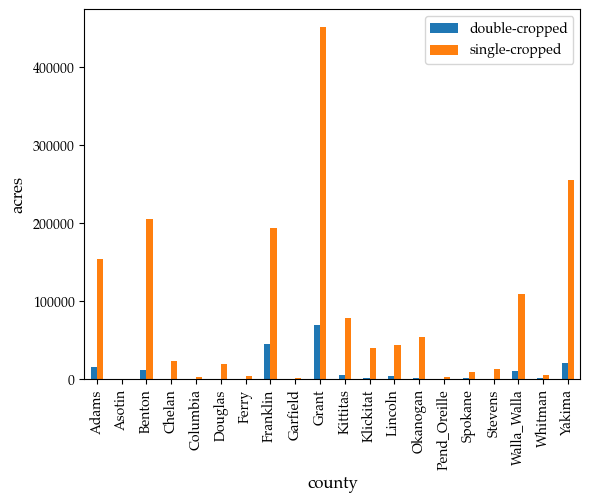

In [28]:
plot_col = "acres"
df = county_nofilter_labelsCountAcr.copy()
df = df.pivot(index="county", columns="label", values=plot_col).reset_index(drop=False)
df.columns = df.columns.values
df.plot(x="county", kind="bar", stacked=False)
# title=plot_col
plt.xlabel("county")
plt.ylabel(plot_col)

In [29]:
import plotly.express as px

df = county_nofilter_labelsCountAcr.copy()
fig = px.bar(df, x="county", y="acres", color="label", barmode="group", text="acres", height=400)
fig.update_xaxes(categoryorder="array", categoryarray=df.county.unique())

# fig.update_layout(font=dict(# textfont_size=20, family="Courier New, monospace",
#                             size=18,  # Set the font size here
#                             color="RebeccaPurple"))
# fig.update_traces(textfont_size=80)

# file_name = data_dir_ + "county_2022_nofilter_labelsAcr.pdf"
# fig.write_image(file_name) need to install kaleido
fig.show()

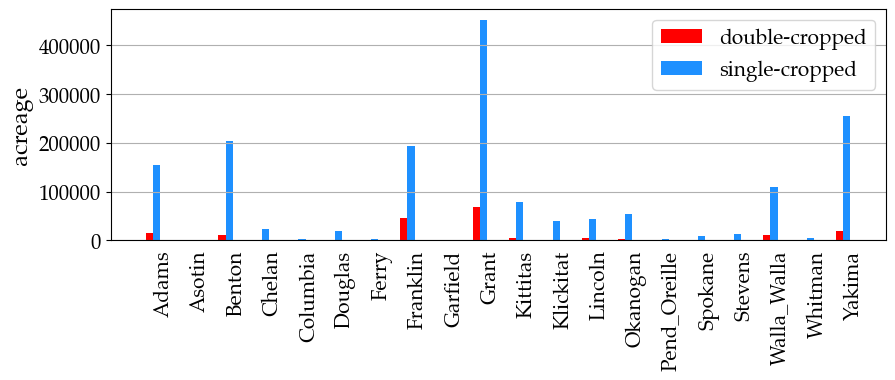

In [143]:
plot_col = "acres"
df = county_nofilter_labelsCountAcr.copy()
df = df.pivot(index="county", columns="label", values=plot_col).reset_index(drop=False)
df.fillna(0, inplace=True)
df.sort_values(by=["county"], inplace=True)
df.reset_index(drop=True, inplace=True)

fig, axs = plt.subplots(1, 1, figsize=(10, 3), sharex=False, gridspec_kw={"hspace": 0.35, "wspace": 0.05})
axs.grid(axis="y", which="both")
X_axis = np.arange(len(df.county))

bar_width_ = 1
step_size_ = 5 * bar_width_
X_axis = np.array(range(0, step_size_ * len(df.county), step_size_))

axs.bar(X_axis - bar_width_ * 2, df["double-cropped"], color=color_dict["double-cropped"],
        width=bar_width_, label="double-cropped",)

axs.bar(X_axis - bar_width_, df["single-cropped"], color=color_dict["single-cropped"],
        width=bar_width_, label="single-cropped")

axs.tick_params(axis="x", labelrotation=90)
axs.set_xticks(X_axis, df.county)

axs.set_ylabel("acreage")
axs.legend(loc="best")
axs.xaxis.set_ticks_position("none")
ymin, ymax = axs.get_ylim();

axs.set(ylim=(ymin - 1, ymax + 25), axisbelow=True); # send the guidelines back

In [31]:
tick_legend_FontSize = 10
params = {
    "legend.fontsize": tick_legend_FontSize * 1.5,  # medium, large
    "axes.labelsize": tick_legend_FontSize * 1.7,
    "axes.titlesize": tick_legend_FontSize * 1.7,
    "xtick.labelsize": tick_legend_FontSize * 1.5,  #  * 0.75
    "ytick.labelsize": tick_legend_FontSize * 1.5,  #  * 0.75
    "axes.titlepad": 10,
    "font.size": 14,
}

plt.rc("font", family="Palatino")
plt.rcParams["xtick.bottom"] = True
plt.rcParams["ytick.left"] = True
plt.rcParams["xtick.labelbottom"] = True
plt.rcParams["ytick.labelleft"] = True
plt.rcParams.update(params)

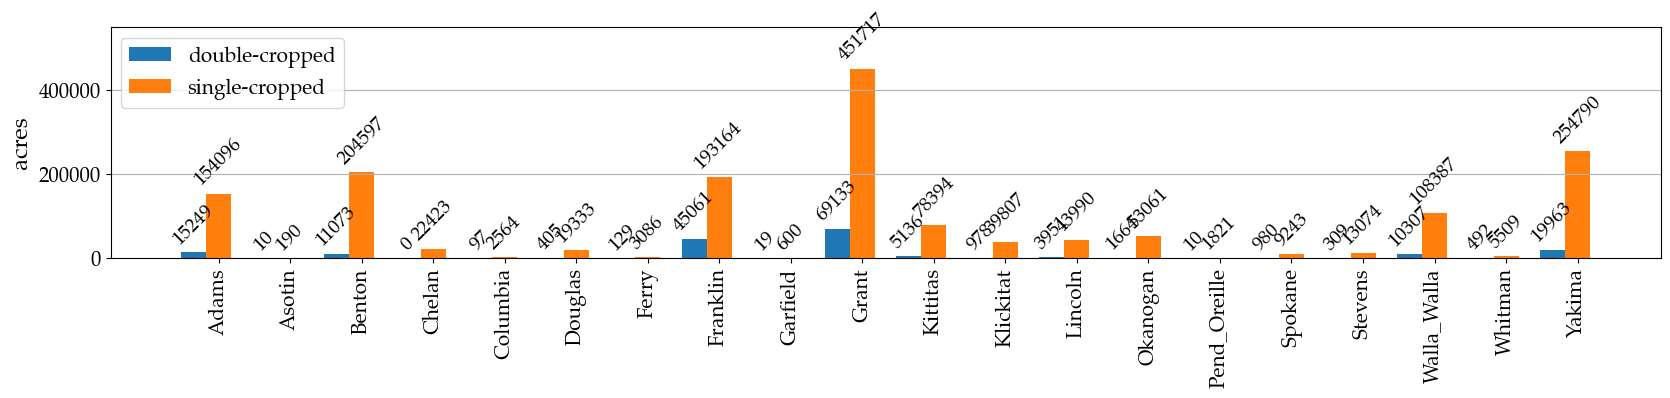

In [35]:
# https://matplotlib.org/stable/gallery/lines_bars_and_markers/barchart.html
plot_col = "acres"
df = county_nofilter_labelsCountAcr.copy()
df = df.pivot(index="county", columns="label", values=plot_col).reset_index(drop=False)
df.fillna(0, inplace=True)
df.sort_values(by=["county"], inplace=True)
df.reset_index(drop=True, inplace=True)
counties = list(df.county.unique())

x = np.arange(len(counties))  # the label locations
width, multiplier = 0.35, 0  # the width of the bars

fig, ax = plt.subplots(1, 1, figsize=(20, 3), sharex=False,  # sharey='col', # sharex=True, sharey=True,
    gridspec_kw={"hspace": 0.35, "wspace": 0.05})
ax.grid(axis="y", which="both")

for a_col in ["double-cropped", "single-cropped"]:
    offset = width * multiplier
    rects = ax.bar(x + offset, df[a_col], width, label=a_col)
    ax.bar_label(rects, padding=3, label_type="edge", rotation=45)
    multiplier += 1

ax.set_ylim([0, 550000])
ax.set_ylabel(plot_col)
ax.set_xticks(x + width, counties)
ax.legend(loc="upper left", ncols=1)
ax.tick_params(axis="x", labelrotation=90)
file_name = data_dir_ + "county_2022_nofilter_labelsAcr.pdf"
# plt.savefig(fname=file_name, dpi=200, bbox_inches="tight", transparent=False)
plt.show()

In [36]:
width

0.35

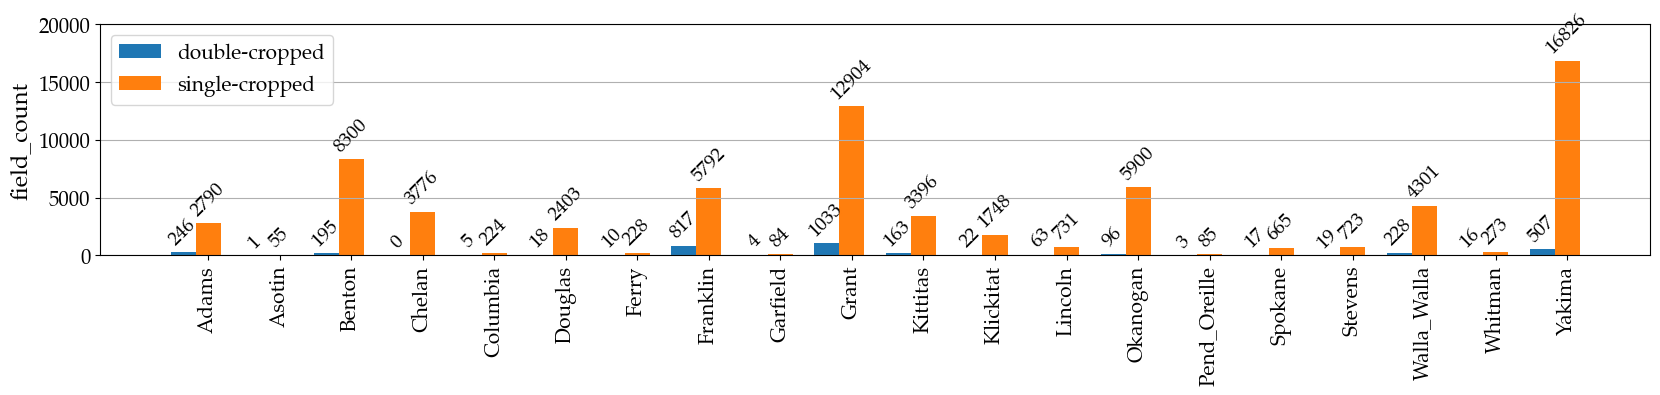

In [38]:
# https://matplotlib.org/stable/gallery/lines_bars_and_markers/barchart.html
plot_col = "field_count"
df = county_nofilter_labelsCountAcr.copy()
df = df.pivot(index="county", columns="label", values=plot_col).reset_index(drop=False)
df.fillna(0, inplace=True)
df.sort_values(by=["county"], inplace=True)
df.reset_index(drop=True, inplace=True)
counties = list(df.county.unique())

x, multiplier = np.arange(len(counties)), 0  # the label locations

fig, ax = plt.subplots(1, 1, figsize=(20, 3), sharex=False,  # sharey='col', # sharex=True, sharey=True,
                       gridspec_kw={"hspace": 0.35, "wspace": 0.05})
ax.grid(axis="y", which="both")

for a_col in ["double-cropped", "single-cropped"]:
    offset = width * multiplier
    rects = ax.bar(x + offset, df[a_col], width, label=a_col)
    ax.bar_label(rects, padding=3, label_type="edge", rotation=45)
    multiplier += 1

ax.set_ylim([0, 20000])
ax.set_ylabel(plot_col)
ax.set_xticks(x + width, counties)
ax.legend(loc="upper left", ncols=1)
ax.tick_params(axis="x", labelrotation=90)
file_name = data_dir_ + "county_2022_nofilter_labelsCount.pdf"
# plt.savefig(fname=file_name, dpi=200, bbox_inches="tight", transparent=False)
plt.show()

# Put all seed crops in one category

In [39]:
seed_idx = all_correct_year.loc[all_correct_year["croptyp"].str.contains("seed")].index
all_correct_year.loc[seed_idx, "croptyp"] = "seed crops"

In [40]:
potential_2D = [
    "alfalfa hay",
    "alfalfa/grass hay",
    "barley",
    "barley hay",
    "bean, dry",
    "bean, garbanzo",
    "bean, green",
    "buckwheat",
    "canola",
    "carrot",
    "clover/grass hay",
    "corn, field",
    "corn, sweet",
    "grass hay",
    "hops",
    "market crops",
    "oat",
    "oat hay",
    "onion",
    "pasture",
    "pea hay",
    "pea, dry",
    "pea, green",
    "potato",
    "pumpkin",
    "rye",
    "rye hay",
    "seed crops",
    "soybean",
    "spinach",
    "sudangrass",
    "sunflower",
    "timothy",
    "tomato",
    "triticale",
    "triticale hay",
    "wheat",
    "wheat fallow",
    "wheat hay",
    "yellow mustard",
]

perennials = [x for x in sorted(list(all_correct_year.croptyp.unique())) if not (x in potential_2D)]

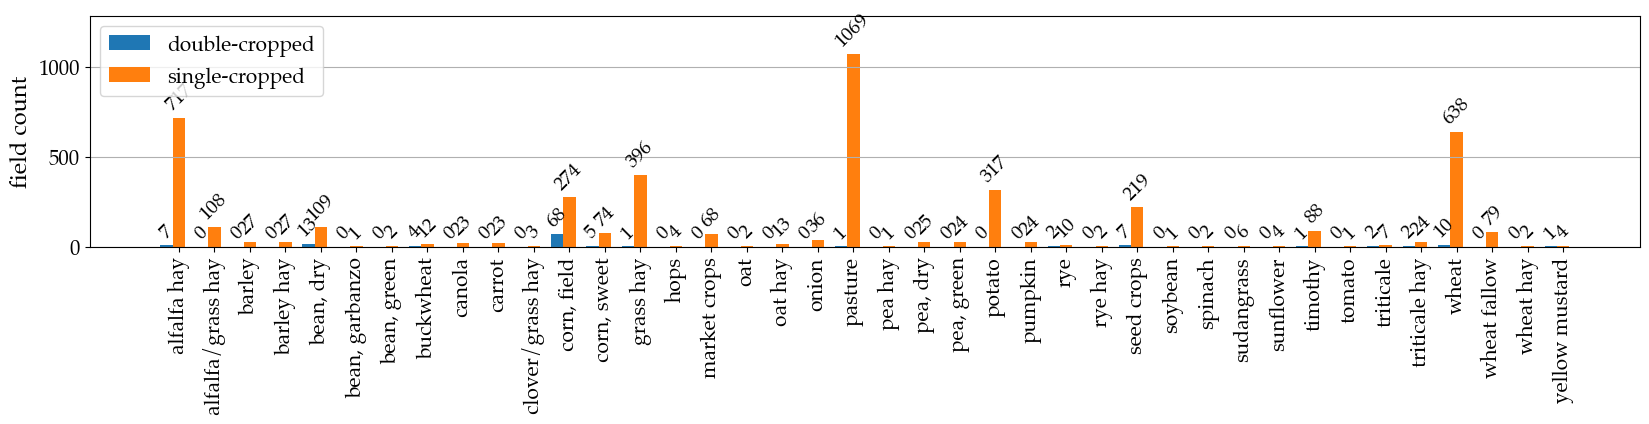

In [41]:
# https://matplotlib.org/stable/gallery/lines_bars_and_markers/barchart.html
yr = 2022
plot_col = "id"

y_lim_multi = 0.2

df = pd.DataFrame(
    all_correct_year[all_correct_year["image_year"] == yr].groupby(["croptyp", "label"])["id"].count()
).reset_index()
df = df[df.croptyp.isin(potential_2D)]
y_lim_max_ = df[plot_col].max() + df[plot_col].max() * y_lim_multi

df = df.pivot(index="croptyp", columns="label", values=plot_col).reset_index(drop=False)
df.fillna(0, inplace=True)
df.sort_values(by=["croptyp"], inplace=True)
df.reset_index(drop=True, inplace=True)
counties = list(df["croptyp"].unique())

x, multiplier = np.arange(len(counties)), 0  # the label locations

fig, ax = plt.subplots(1, 1, figsize=(20, 3), sharex=False,  # sharey='col', # sharex=True, sharey=True,
    gridspec_kw={"hspace": 0.35, "wspace": 0.05})
ax.grid(axis="y", which="both")

for a_col in ["double-cropped", "single-cropped"]:
    offset = width * multiplier
    rects = ax.bar(x + offset, df[a_col], width, label=a_col)
    ax.bar_label(rects, padding=3, label_type="edge", rotation=45)
    multiplier += 1

ax.set_ylim([0, y_lim_max_])
if plot_col == "id":
    ax.set_ylabel("field count")
else:
    ax.set_ylabel(plot_col)

ax.set_xticks(x + width, counties)
ax.legend(loc="upper left", ncols=1)
ax.tick_params(axis="x", labelrotation=90)
file_name = data_dir_ + "crop_2022_filter_labelsCount_potential2D.pdf"
# plt.savefig(fname = file_name, dpi=200, bbox_inches='tight', transparent=False);
plt.show()

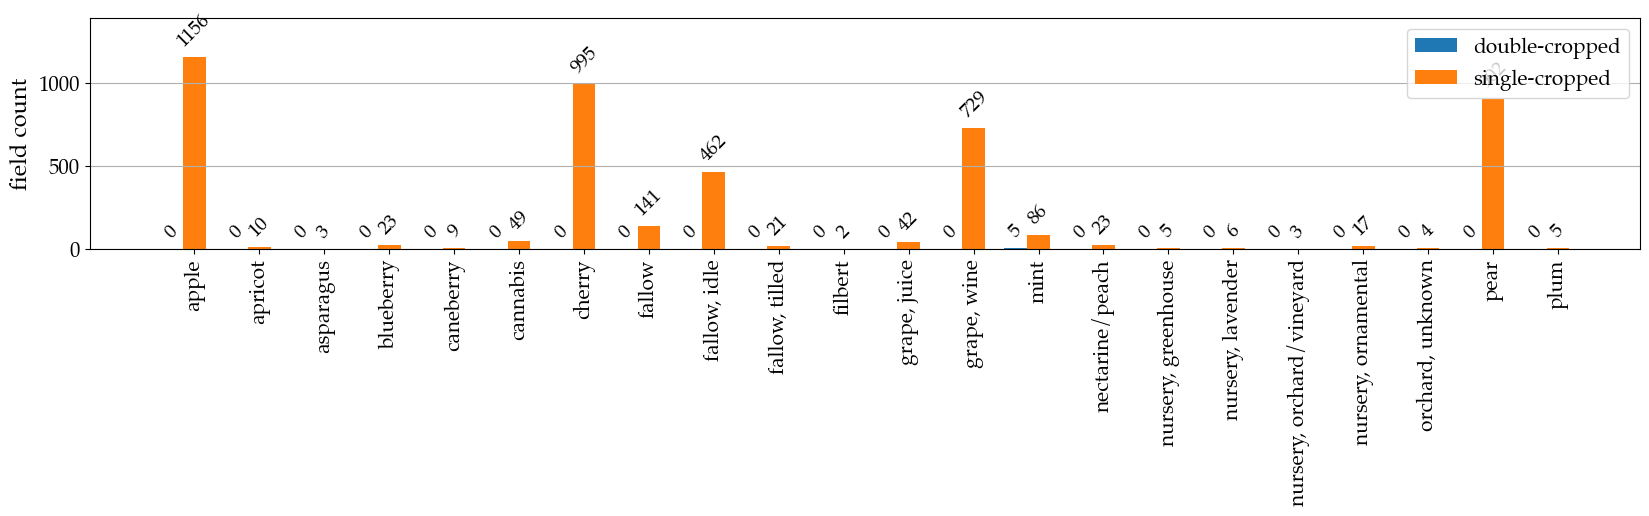

In [42]:
# https://matplotlib.org/stable/gallery/lines_bars_and_markers/barchart.html
plot_col = "id"
df = pd.DataFrame(
    all_correct_year[all_correct_year["image_year"] == yr].groupby(["croptyp", "label"])["id"].count()
).reset_index()
df = df[df.croptyp.isin(perennials)]
y_lim_max_ = df[plot_col].max() + df[plot_col].max() * y_lim_multi

df = df.pivot(index="croptyp", columns="label", values=plot_col).reset_index(drop=False)
df.fillna(0, inplace=True)
df.sort_values(by=["croptyp"], inplace=True)
df.reset_index(drop=True, inplace=True)
counties = list(df["croptyp"].unique())

x, multiplier = np.arange(len(counties)), 0  # the label locations

fig, ax = plt.subplots(1, 1, figsize=(20, 3), sharex=False,  # sharey='col', # sharex=True, sharey=True,
                       gridspec_kw={"hspace": 0.35, "wspace": 0.05})
ax.grid(axis="y", which="both")

for a_col in ["double-cropped", "single-cropped"]:
    offset = width * multiplier
    rects = ax.bar(x + offset, df[a_col], width, label=a_col)
    ax.bar_label(rects, padding=5, label_type="edge", rotation=45)
    multiplier += 1

ax.set_ylim([0, y_lim_max_])
if plot_col == "id":
    ax.set_ylabel("field count")
else:
    ax.set_ylabel(plot_col)

ax.set_xticks(x + width, counties)
ax.legend(loc="best", ncols=1)
ax.tick_params(axis="x", labelrotation=90)
file_name = data_dir_ + "crop_2022_filter_labelsCount_perennials.pdf"
# plt.savefig(fname = file_name, dpi=200, bbox_inches='tight', transparent=False);
plt.show()

## Filtered tables

In [43]:
yr = 2021
L = len(all_correct_year[all_correct_year["image_year"] == yr]["id"].unique())
print("total number of fields is [{}].".format(L))
print("total acre is [{}].".format(all_correct_year[all_correct_year["image_year"] == yr]["acres"].sum()))

total number of fields is [33260].
total acre is [733569].


In [44]:
pd.DataFrame(all_correct_year[all_correct_year["image_year"] == yr].groupby("label")["id"].count()).reset_index()

label     id
0  double-cropped   1724
1  single-cropped  31536

In [45]:
pd.DataFrame(all_correct_year[all_correct_year["image_year"] == yr].groupby("label")["acres"].sum()).reset_index()

label   acres
0  double-cropped   80569
1  single-cropped  653000

# Write for-loops

There are too may options:
  - filtered or not
  - 2022 or 2023
  - crop-wise or county-wise
    - in case of crop-wise: 2D or perennials
   - Acres or fiel-count

## For-loop for county-wise

Since we do not have 2D or perennials I am writing two for-loops. Easier to manage the loops as well.

In [46]:
params = {"legend.fontsize": tick_legend_FontSize,  # medium, large
          "axes.labelsize": tick_legend_FontSize * 1,
          "axes.titlesize": tick_legend_FontSize * 1,
          "xtick.labelsize": tick_legend_FontSize,  #  * 0.75
          "ytick.labelsize": tick_legend_FontSize}
plt.rcParams.update(params)

params = {"legend.fontsize": tick_legend_FontSize * 1.5,  # medium, large
          "axes.labelsize": tick_legend_FontSize * 1.7,
          "axes.titlesize": tick_legend_FontSize * 1.7,
          "xtick.labelsize": tick_legend_FontSize * 1.5,  #  * 0.75
          "ytick.labelsize": tick_legend_FontSize * 1.5}
plt.rcParams.update(params)

In [45]:
filter_ = [True, False]
plot_what = ["id", "acres"]

counter = 1
for a_year in years:
    for a_filter in filter_:
        for plot_col in plot_what:
            if plot_col == "id":
                if a_filter == True:
                    df = all_correct_year[all_correct_year["image_year"] == a_year].copy()
                elif a_filter == False:                    
                    df = all_no_filter[all_no_filter["image_year"] == a_year].copy()

                y_label_ = "field count"
                df = pd.DataFrame(df.groupby(["county", "label"])["id"].count()).reset_index()
                y_lim_max_ = df[plot_col].max() + df[plot_col].max() * y_lim_multi

                df = df.pivot(index="county", columns="label", values=plot_col).reset_index(drop=False)
                df.fillna(0, inplace=True)
                df.sort_values(by=["county"], inplace=True)
                df.reset_index(drop=True, inplace=True)
                counties = list(df["county"].unique())

                x = np.arange(len(counties))  # the label locations
                width, multiplier = 0.25, 0  # the width of the bars

                fig, ax = plt.subplots(1, 1, figsize=(20, 3), sharex=False,
                                       gridspec_kw={"hspace": 0.35, "wspace": 0.05})
                ax.grid(axis="y", which="both")

                for a_col in ["double-cropped", "single-cropped"]:
                    offset = width * multiplier
                    rects = ax.bar(x + offset, df[a_col], width, label=a_col)
                    ax.bar_label(rects, padding=3, label_type="edge", rotation=45)
                    multiplier += 1

                ax.set_ylim([0, y_lim_max_])
                if plot_col == "id":
                    ax.set_ylabel(y_label_)
                else:
                    ax.set_ylabel(plot_col)

                ax.set_xticks(x + width, counties)
                ax.legend(loc="best", ncols=1)
                ax.tick_params(axis="x", labelrotation=90)
                ymin, ymax = ax.get_ylim()
                ax.set(ylim=(ymin - 1, ymax + 25), axisbelow=True) # send the guidelines back
                ax.set_title(f"Year {a_year}. srvy filter: {a_filter}. {y_label_}")
                file_name = plot_dir+ f"county_{a_year}_filter{a_filter}_{y_label_.replace(' ', '_')}.pdf"

                plt.savefig(fname=file_name, dpi=200, bbox_inches="tight", transparent=False)
                plt.close()

            if plot_col == "acres":
                if a_filter == True:
                    df = all_correct_year[all_correct_year["image_year"] == a_year].copy()
                elif a_filter == False:
                    df = all_no_filter[all_no_filter["image_year"] == a_year].copy()
                    
                df = df[["county", "label", "acres"]]
                df = pd.DataFrame(df.groupby(["county", "label"])["acres"].sum()).reset_index()
                y_lim_max_ = df[plot_col].max() + df[plot_col].max() * y_lim_multi
                df = df.pivot(index="county", columns="label", values=plot_col).reset_index(drop=False)

                df.fillna(0, inplace=True)
                df.sort_values(by=["county"], inplace=True)
                df.reset_index(drop=True, inplace=True)
                counties = list(df.county.unique())

                x = np.arange(len(counties))  # the label locations
                width, multiplier = 0.35, 0  # the width of the bars

                fig, ax = plt.subplots(1, 1, figsize=(20, 3), sharex=False,
                                       gridspec_kw={"hspace": 0.35, "wspace": 0.05})
                ax.grid(axis="y", which="both")

                for a_col in ["double-cropped", "single-cropped"]:
                    offset = width * multiplier
                    rects = ax.bar(x + offset, df[a_col], width, label=a_col)
                    ax.bar_label(rects, padding=3, label_type="edge", rotation=45)
                    multiplier += 1

                ax.set_ylim([0, y_lim_max_])
                ax.set_ylabel(plot_col)
                ax.set_xticks(x + width, counties)
                ax.legend(loc="best", ncols=1)
                ax.tick_params(axis="x", labelrotation=90)

                ymin, ymax = ax.get_ylim()
                ax.set(ylim=(ymin - 1, ymax + 25), axisbelow=True) # send the guidelines back
                ax.set_title(f"Year {a_year}. srvy filter: {a_filter}. {plot_col}")
                file_name = (plot_dir + f"county_{a_year}_filter{a_filter}_{plot_col}.pdf")

                plt.savefig(fname=file_name, dpi=200, bbox_inches="tight", transparent=False)
                plt.close()

# Percentages

In [166]:
filter_ = [True, False]
plot_what = ["id", "acres"]

perc_plot_dir_ = plot_dir + "percentages/"
os.makedirs(perc_plot_dir_, exist_ok=True)
y_lim_max_ = 110
counter = 1
for a_year in years:
    for a_filter in filter_:
        for plot_col in plot_what:
            if plot_col == "id":
                if a_filter == True:
                    df = all_correct_year[all_correct_year["image_year"] == a_year].copy()
                elif a_filter == False:                    
                    df = all_no_filter[all_no_filter["image_year"] == a_year].copy()

                y_label_ = "field count percentage"
                df = pd.DataFrame(df.groupby(["county", "label"])["id"].count()).reset_index()

                df = df.pivot(index="county", columns="label", values=plot_col).reset_index(drop=False)
                df.fillna(0, inplace=True)
                df.sort_values(by=["county"], inplace=True)
                df.reset_index(drop=True, inplace=True)
                counties = list(df["county"].unique())

                x = np.arange(len(counties))  # the label locations
                width, multiplier = 0.25, 0  # the width of the bars
                
                df["double_perc"] = 100 * df["double-cropped"] / (df["double-cropped"] + df["single-cropped"])
                df["single_perc"] = 100 * df["single-cropped"] / (df["double-cropped"] + df["single-cropped"])
                df["double_perc"] = df["double_perc"].round()
                df["single_perc"] = df["single_perc"].round()

                fig, ax = plt.subplots(1, 1, figsize=(20, 3), sharex=False,
                                       gridspec_kw={"hspace": 0.35, "wspace": 0.05})
                ax.grid(axis="y", which="both")

                for a_col in ["double_perc", "single_perc"]:
                    offset = width * multiplier
                    rects = ax.bar(x + offset, df[a_col], width, label=a_col)
                    ax.bar_label(rects, padding=3, label_type="edge", rotation=45)
                    multiplier += 1

                ax.set_ylim([0, y_lim_max_])
                if plot_col == "id":
                    ax.set_ylabel(y_label_)
                else:
                    ax.set_ylabel(plot_col)

                ax.set_xticks(x + width, counties)
                ax.legend(loc="best", ncols=1)
                ax.tick_params(axis="x", labelrotation=90)
                ymin, ymax = ax.get_ylim()
                ax.set(ylim=(ymin - 1, ymax + 25), axisbelow=True) # send the guidelines back
                ax.set_title(f"Year {a_year}. srvy filter: {a_filter}. {y_label_}")
                file_name = perc_plot_dir_+ \
                            f"county_{a_year}_filter{a_filter}_{y_label_.replace(' ', '_')}_perc.pdf"

                plt.savefig(fname=file_name, dpi=200, bbox_inches="tight", transparent=False)
                plt.close()

            if plot_col == "acres":
                if a_filter == True:
                    df = all_correct_year[all_correct_year["image_year"] == a_year].copy()
                elif a_filter == False:
                    df = all_no_filter[all_no_filter["image_year"] == a_year].copy()
                    
                df = df[["county", "label", "acres"]]
                df = pd.DataFrame(df.groupby(["county", "label"])["acres"].sum()).reset_index()
                df = df.pivot(index="county", columns="label", values=plot_col).reset_index(drop=False)

                df.fillna(0, inplace=True)
                df.sort_values(by=["county"], inplace=True)
                df.reset_index(drop=True, inplace=True)
                counties = list(df.county.unique())
                
                df["double_perc"] = 100 * df["double-cropped"] / (df["double-cropped"] + df["single-cropped"])
                df["single_perc"] = 100 * df["single-cropped"] / (df["double-cropped"] + df["single-cropped"])
                df["double_perc"] = df["double_perc"].round()
                df["single_perc"] = df["single_perc"].round()

                x = np.arange(len(counties))  # the label locations
                width, multiplier = 0.35, 0  # the width of the bars

                fig, ax = plt.subplots(1, 1, figsize=(20, 3), sharex=False,
                                       gridspec_kw={"hspace": 0.35, "wspace": 0.05})
                ax.grid(axis="y", which="both")

                for a_col in ["double_perc", "single_perc"]:
                    offset = width * multiplier
                    rects = ax.bar(x + offset, df[a_col], width, label=a_col)
                    ax.bar_label(rects, padding=3, label_type="edge", rotation=45)
                    multiplier += 1

                ax.set_ylim([0, y_lim_max_])
                ax.set_ylabel(plot_col + " percentage")
                ax.set_xticks(x + width, counties)
                ax.legend(loc="best", ncols=1)
                ax.tick_params(axis="x", labelrotation=90)

                ymin, ymax = ax.get_ylim()
                ax.set(ylim=(ymin - 1, ymax + 25), axisbelow=True) # send the guidelines back
                ax.set_title(f"Year {a_year}. srvy filter: {a_filter}. {plot_col}")
                file_name = (perc_plot_dir_ + f"county_{a_year}_filter{a_filter}_{plot_col}_perc.pdf")
                plt.savefig(fname=file_name, dpi=200, bbox_inches="tight", transparent=False)
                plt.close()

# Crop-wise plots

filter_ must be True

In [141]:
params = {
    "legend.fontsize": tick_legend_FontSize * 1.5,  # medium, large
    "axes.labelsize": tick_legend_FontSize * 1.7,
    "axes.titlesize": tick_legend_FontSize * 1.7,
    "xtick.labelsize": tick_legend_FontSize * 1.5,  #  * 0.75
    "ytick.labelsize": tick_legend_FontSize * 1.5,
}
plt.rcParams.update(params)

y_lim_multi = 0.25

In [47]:
perennials_choice = [True, False]
filter_ = [True]
counter = 1

for a_year in years:
    for a_filter in filter_:
        for plot_col in plot_what:
            for perennial in perennials_choice:
                if plot_col == "id":
                    if a_filter == True:
                        df = all_correct_year[all_correct_year["image_year"] == a_year].copy()
                    elif a_filter == False:
                        df = all_no_filter[all_no_filter["image_year"] == a_year].copy()
                        
                    if perennial == True:
                        df = df[df.croptyp.isin(perennials)].copy()
                        lastName = "perennial"
                        plot_width_ = 20
                    else:
                        df = df[df.croptyp.isin(potential_2D)].copy()
                        lastName = "2D"
                        plot_width_ = 30

                    y_label_ = "field count"
                    df = pd.DataFrame(df.groupby(["croptyp", "label"])["id"].count()).reset_index()
                    y_lim_max_ = df[plot_col].max() + df[plot_col].max() * y_lim_multi

                    df = df.pivot(index="croptyp", columns="label", values=plot_col).reset_index(drop=False)
                    df.fillna(0, inplace=True)
                    df.sort_values(by=["croptyp"], inplace=True)
                    df.reset_index(drop=True, inplace=True)
                    crop_types = list(df["croptyp"].unique())

                    x = np.arange(len(crop_types))  # the label locations
                    width, multiplier = 0.25, 0  # the width of the bars

                    fig, ax = plt.subplots(1, 1, figsize=(plot_width_, 3), sharex=False,
                        gridspec_kw={"hspace": 0.35, "wspace": 0.05})
                    ax.grid(axis="y", which="both")

                    for a_col in ["double-cropped", "single-cropped"]:
                        offset = width * multiplier
                        rects = ax.bar(x + offset, df[a_col], width, label=a_col)
                        ax.bar_label(rects, padding=3, label_type="edge", rotation=90,
                                     fontsize=tick_legend_FontSize*1.7)
                        multiplier += 1

                    ax.set_ylim([0, y_lim_max_])
                    if plot_col == "id":
                        ax.set_ylabel(y_label_)
                    else:
                        ax.set_ylabel(plot_col)

                    ax.set_xticks(x + width, crop_types)
                    ax.legend(loc="best", ncols=1)
                    ax.tick_params(axis="x", labelrotation=90)
                    ax.set_title(f"Year {a_year}. srvy filter: {a_filter}. {y_label_}")
                    ymin, ymax = ax.get_ylim()
                    ax.set(ylim=(ymin - 1, ymax + 25), axisbelow=True) # send the guidelines back

                    file_name = plot_dir+\
                                f"crop_{a_year}_filter{a_filter}_{y_label_.replace(' ', '_')}_{lastName}.pdf"

                    plt.savefig(fname=file_name, dpi=200, bbox_inches="tight", transparent=False)
                    plt.close()

                if plot_col == "acres":
                    y_label_ = "acres"
                    if a_filter == True:
                        df = all_correct_year[all_correct_year["image_year"] == a_year].copy()
                    elif a_filter == False:
                        df = all_no_filter[all_no_filter["image_year"] == a_year].copy()

                    if perennial == True:
                        df = df[df.croptyp.isin(perennials)].copy()
                        lastName = "perennial"
                    else:
                        df = df[df.croptyp.isin(potential_2D)].copy()
                        lastName = "2D"
                    df = pd.DataFrame(df.groupby(["croptyp", "label"])["acres"].sum()).reset_index()
                    y_lim_max_ = df[plot_col].max() + df[plot_col].max() * y_lim_multi
                    df = df.pivot(index="croptyp", columns="label", values=plot_col).reset_index(drop=False)

                    df.fillna(0, inplace=True)
                    df.sort_values(by=["croptyp"], inplace=True)
                    df.reset_index(drop=True, inplace=True)
                    crop_types = list(df.croptyp.unique())

                    x = np.arange(len(crop_types)) # the label locations
                    width, multiplier = 0.35, 0  # the width of the bars

                    fig, ax = plt.subplots(1, 1, figsize=(plot_width_, 3), sharex=False,
                        gridspec_kw={"hspace": 0.35, "wspace": 0.05})
                    ax.grid(axis="y", which="both")

                    for a_col in ["double-cropped", "single-cropped"]:
                        offset = width * multiplier
                        rects = ax.bar(x + offset, df[a_col], width, label=a_col)
                        ax.bar_label(rects, padding=3, label_type="edge", rotation=90, 
                                     fontsize=tick_legend_FontSize*1.7)
                        multiplier += 1

                    ax.set_ylim([0, y_lim_max_])
                    ax.set_ylabel(plot_col)
                    ax.set_xticks(x + width, crop_types)
                    ax.legend(loc="best", ncols=1)
                    ax.tick_params(axis="x", labelrotation=90)
                    ymin, ymax = ax.get_ylim()
                    ax.set(ylim=(ymin - 1, ymax + 25), axisbelow=True) # send the guidelines back

                    ax.set_title(f"Year {a_year}. srvy filter: {a_filter}. {y_label_}")
                    file_name = (plot_dir+\
                        f"crop_{a_year}_filter{a_filter}_{plot_col}_{lastName}.pdf")

                    plt.savefig(fname=file_name, dpi=200, bbox_inches="tight", transparent=False)
                    plt.close()

# Crop-wise percentages

In [169]:
perennials_choice = [True, False]
filter_ = [True]
counter = 1
y_lim_max_ = 110

for a_year in years:
    for a_filter in filter_:
        for plot_col in plot_what:
            for perennial in perennials_choice:
                if plot_col == "id":
                    if a_filter == True:
                        df = all_correct_year[all_correct_year["image_year"] == a_year].copy()
                    elif a_filter == False:
                        df = all_no_filter[all_no_filter["image_year"] == a_year].copy()
                        
                    if perennial == True:
                        df = df[df.croptyp.isin(perennials)].copy()
                        lastName = "perennial"
                        plot_width_ = 20
                    else:
                        df = df[df.croptyp.isin(potential_2D)].copy()
                        lastName = "2D"
                        plot_width_ = 30

                    y_label_ = "field count percentage"
                    df = pd.DataFrame(df.groupby(["croptyp", "label"])["id"].count()).reset_index()
                    df = df.pivot(index="croptyp", columns="label", values=plot_col).reset_index(drop=False)
                    df.fillna(0, inplace=True)
                    df.sort_values(by=["croptyp"], inplace=True)
                    df.reset_index(drop=True, inplace=True)
                    crop_types = list(df["croptyp"].unique())
                    
                    df["double_perc"] = 100 * df["double-cropped"] / (df["double-cropped"] + df["single-cropped"])
                    df["single_perc"] = 100 * df["single-cropped"] / (df["double-cropped"] + df["single-cropped"])
                    df["double_perc"] = df["double_perc"].round()
                    df["single_perc"] = df["single_perc"].round()

                    x = np.arange(len(crop_types)) # the label locations
                    width, multiplier = 0.25, 0  # the width of the bars

                    fig, ax = plt.subplots(1, 1, figsize=(plot_width_, 3), sharex=False,
                                           gridspec_kw={"hspace": 0.35, "wspace": 0.05})
                    ax.grid(axis="y", which="both")

                    for a_col in ["double_perc", "single_perc"]:
                        offset = width * multiplier
                        rects = ax.bar(x + offset, df[a_col], width, label=a_col)
                        ax.bar_label(rects, padding=3, label_type="edge", rotation=90,
                                     fontsize=tick_legend_FontSize*1.7)
                        multiplier += 1

                    ax.set_ylim([0, y_lim_max_])
                    if plot_col == "id":
                        ax.set_ylabel(y_label_)
                    else:
                        ax.set_ylabel(plot_col)

                    ax.set_xticks(x + width, crop_types)
                    ax.legend(loc="best", ncols=1)
                    ax.tick_params(axis="x", labelrotation=90)
                    ax.set_title(f"Year {a_year}. srvy filter: {a_filter}. {y_label_}")

                    ymin, ymax = ax.get_ylim()
                    ax.set(ylim=(ymin - 1, ymax + 25), axisbelow=True) # send the guidelines back
                    file_name = perc_plot_dir_+\
                            f"crop_{a_year}_filter{a_filter}_{y_label_.replace(' ', '_')}_{lastName}_perc.pdf"

                    plt.savefig(fname=file_name, dpi=200, bbox_inches="tight", transparent=False)
                    plt.close()

                if plot_col == "acres":
                    y_label_ = "acres percentage"
                    if a_filter == True:
                        df = all_correct_year[all_correct_year["image_year"] == a_year].copy()
                    elif a_filter == False:
                        df = all_no_filter[all_no_filter["image_year"] == a_year].copy()

                    if perennial == True:
                        df = df[df.croptyp.isin(perennials)].copy()
                        lastName = "perennial"
                    else:
                        df = df[df.croptyp.isin(potential_2D)].copy()
                        lastName = "2D"
                    df = pd.DataFrame(df.groupby(["croptyp", "label"])["acres"].sum()).reset_index()
                    df = df.pivot(index="croptyp", columns="label", values=plot_col).reset_index(drop=False)

                    df.fillna(0, inplace=True)
                    df.sort_values(by=["croptyp"], inplace=True)
                    df.reset_index(drop=True, inplace=True)
                    crop_types = list(df.croptyp.unique())
                    
                    df["double_perc"] = 100 * df["double-cropped"] / (df["double-cropped"] + df["single-cropped"])
                    df["single_perc"] = 100 * df["single-cropped"] / (df["double-cropped"] + df["single-cropped"])
                    df["double_perc"] = df["double_perc"].round()
                    df["single_perc"] = df["single_perc"].round()

                    x = np.arange(len(crop_types)) # the label locations
                    width, multiplier = 0.35, 0  # the width of the bars

                    fig, ax = plt.subplots(1, 1, figsize=(plot_width_, 3), sharex=False,
                                           gridspec_kw={"hspace": 0.35, "wspace": 0.05})
                    ax.grid(axis="y", which="both")

                    for a_col in ["double_perc", "single_perc"]:
                        offset = width * multiplier
                        rects = ax.bar(x + offset, df[a_col], width, label=a_col)
                        ax.bar_label(rects, padding=3, label_type="edge", rotation=90, 
                                     fontsize=tick_legend_FontSize*1.7)
                        multiplier += 1

                    ax.set_ylim([0, y_lim_max_])
                    ax.set_ylabel(plot_col + " percentage")
                    ax.set_xticks(x + width, crop_types)
                    ax.legend(loc="best", ncols=1)
                    ax.tick_params(axis="x", labelrotation=90)
                    ymin, ymax = ax.get_ylim()
                    ax.set(ylim=(ymin - 1, ymax + 25), axisbelow=True) # send the guidelines back
                    ax.set_title(f"Year {a_year}. srvy filter: {a_filter}. {y_label_}")
                    file_name = (perc_plot_dir_+\
                                 f"crop_{a_year}_filter{a_filter}_{plot_col}_{lastName}_perc.pdf")

                    plt.savefig(fname=file_name, dpi=200, bbox_inches="tight", transparent=False)
                    plt.close()

In [51]:
(Joel_QAQC_V3_df["DoubleCrop"] == Joel_QAQC_V3_df["DoubleCrop_pred"]).sum()

31

In [52]:
Joel_QAQC_V3_df["DoubleCrop"] == Joel_QAQC_V3_df["DoubleCrop_pred"]

0      False
1       True
2      False
3      False
4       True
       ...  
106     True
107    False
108    False
109    False
110    False
Length: 111, dtype: bool

In [53]:
Joel_QAQC_V3_df.last_survey_year.unique()

array([2023., 2022.,   nan])

In [54]:
Joel_QAQC_V3_df[Joel_QAQC_V3_df.OBJECTID == 21552]

OBJECTID       CropType  Acres    Irrigation               LastSurvey  \
17     21552  Triticale Hay     96  Center Pivot  2023/06/26 00:00:00.000   

   DataSource                            Notes County  ExactAcres DoubleCrop  \
17       WSDA  Field corn trit hay double 2023  Grant   95.635406        Yes   

      label  last_survey_year  image_year DoubleCrop_pred  
17  unknown               NaN         NaN         unknown

In [55]:
Joel_QAQC_V3_df.head(2)

OBJECTID     CropType  Acres    Irrigation               LastSurvey  \
0      6868  Corn, Field     11  Center Pivot  2023/07/20 00:00:00.000   
1     10749  Corn, Field     90  Center Pivot  2022/09/13 00:00:00.000   

  DataSource                                     Notes County  ExactAcres  \
0       WSDA      Double drop after triticale hay 2023  Adams   11.199867   
1       WSDA  Double cropped with triticale hay - 2023  Adams   89.953973   

  DoubleCrop           label  last_survey_year  image_year DoubleCrop_pred  
0        Yes  single-cropped            2023.0      2023.0              No  
1        Yes  double-cropped            2022.0      2022.0             Yes

In [56]:
SF.head(2)

OBJECTID CropType  Acres            Irrigation               InitialSur  \
0         1    Apple     15  Drip/Micro-Sprinkler  2003/07/01 00:00:00.000   
1         2    Apple     11  Drip/Micro-Sprinkler  2003/07/01 00:00:00.000   

                LastSurvey DataSource Notes       TRS County  \
0  2022/09/13 00:00:00.000       WSDA  None  T16R28E4  Adams   
1  2022/09/13 00:00:00.000       WSDA  None  T16R28E4  Adams   

         RotationCr CoverCrop  ExactAcres   SHAPE_Leng    SHAPE_Area  \
0  Orchard, Unknown    <Null>   15.114445  1098.184580  61166.234580   
1  Orchard, Unknown    <Null>   10.804437  1003.907866  43724.181313   

                                            geometry  prob_single  \
0  POLYGON ((-119.31861 46.90127, -119.32374 46.9...          1.0   
1  POLYGON ((-119.32374 46.90126, -119.31861 46.9...          1.0   

            label  last_survey_year  image_year  
0  single-cropped            2022.0      2022.0  
1  single-cropped            2022.0      2022.0

In [57]:
Joel_QAQC_V3_df[Joel_QAQC_V3_df.OBJECTID == 21552]

OBJECTID       CropType  Acres    Irrigation               LastSurvey  \
17     21552  Triticale Hay     96  Center Pivot  2023/06/26 00:00:00.000   

   DataSource                            Notes County  ExactAcres DoubleCrop  \
17       WSDA  Field corn trit hay double 2023  Grant   95.635406        Yes   

      label  last_survey_year  image_year DoubleCrop_pred  
17  unknown               NaN         NaN         unknown

In [58]:
Joel_QAQC_V3_df[Joel_QAQC_V3_df.last_survey_year == 2023].shape

(109, 14)

In [59]:
SF[SF.OBJECTID == 21552]

OBJECTID       CropType  Acres    Irrigation               InitialSur  \
21551     21552  Triticale Hay     96  Center Pivot  2003/07/01 00:00:00.000   

                    LastSurvey DataSource                            Notes  \
21551  2023/06/26 00:00:00.000       WSDA  Field corn trit hay double 2023   

            TRS County   RotationCr CoverCrop  ExactAcres  SHAPE_Leng  \
21551  T17R30E5  Grant  Corn, Field    <Null>   95.635406  2645.28319   

          SHAPE_Area                                           geometry  \
21551  387024.303757  POLYGON ((-119.08049 46.98608, -119.08125 46.9...   

       prob_single label  last_survey_year  image_year  
21551          NaN   NaN               NaN         NaN

In [60]:
# https://matplotlib.org/stable/gallery/lines_bars_and_markers/barchart.html

In [64]:
SG = pd.read_pickle(data_dir_ + "qaqc_NDVI_TS.sav")
SG = SG["SG_TS"]
SG['human_system_start_time'] = pd.to_datetime(SG['human_system_start_time'])
SG.head(2)

ID human_system_start_time      NDVI
0  18367              2023-01-01   0.03834
1  18367              2023-01-19  0.048836

# Big Mistake
It seems the following must be double-cropped. And prediction is single. Just plot

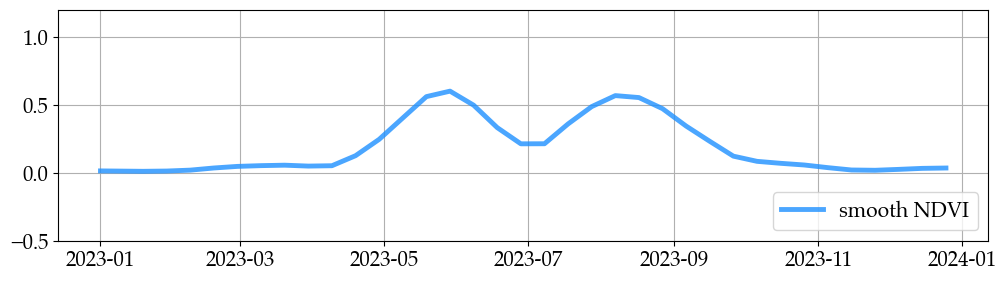

In [67]:
VI_idx = "NDVI"
an_ID = "18523"
a_field = SG[SG.ID==an_ID].copy()

a_field.sort_values(by='human_system_start_time', axis=0, ascending=True, inplace=True)

# Plot
fig, ax = plt.subplots(1, 1, figsize=(12, 3),
                       sharex='col', sharey='row',
                       gridspec_kw={'hspace': 0.2, 'wspace': .05});
ax.grid(True);
ax.plot(a_field['human_system_start_time'], a_field[VI_idx],
        linestyle='-',  linewidth=3.5, color="dodgerblue", alpha=0.8,
        label=f"smooth {VI_idx}")

ax.legend(loc="lower right");
plt.ylim([-0.5, 1.2]);

In [75]:
from tensorflow.keras.utils import to_categorical, load_img, img_to_array
from keras.models import Sequential, Model, load_model
from keras.applications.vgg16 import VGG16
import tensorflow as tf

# from keras.optimizers import SGD
from keras.layers import Conv2D, Dense, Flatten, MaxPooling2D
from tensorflow.keras.optimizers import SGD

# from keras.preprocessing.image import ImageDataGenerator
from keras.src.legacy.preprocessing.image import ImageDataGenerator

In [98]:

#### Form predictions' dataframe
predictions = pd.DataFrame({"ID": list(a_field.ID.unique())})
predictions["prob_single"] = -1.0

ML_model = load_model(data_dir_ + "01_TL_NDVI_SG_train80_Oct17.h5") # load model

image_dir = data_dir_
image_name = image_dir + "fly_test.jpg"

for an_ID in a_field.ID.unique():
    crr_fld = a_field[a_field.ID == an_ID]
    fig, ax = plt.subplots()
    fig.set_size_inches(10, 2.5)
    ax.grid(False)
    ax.plot(crr_fld["human_system_start_time"], crr_fld[VI_idx], c="dodgerblue", linewidth=5)
    ax.axis("off")
    left = crr_fld["human_system_start_time"].values[0]
    right = crr_fld["human_system_start_time"].values[-1]
    ax.set_xlim([left, right]);
    # the following line also works
    ax.set_ylim([-0.005, 1]);

    plt.savefig(fname = image_name, dpi = 200, bbox_inches = "tight", facecolor = "w")
    plt.close("all")

    img = nc.load_image(image_name)
    print (img.shape)
    predictions.loc[predictions.ID == an_ID, "prob_single"] = ML_model.predict(img, verbose=False)[0][0]

(1, 224, 224, 3)


In [97]:
#### Form GoogleDrive_predictions' dataframe
GoogleDrive_predictions = pd.DataFrame({"ID": list(a_field.ID.unique())})
GoogleDrive_predictions["prob_single"] = -1.0

ML_model_GoogleDrive = load_model(data_dir_ + "TL_NDVI_SG.h5") # load model

image_dir = data_dir_
image_name = image_dir + "fly_test.jpg"

for an_ID in a_field.ID.unique():
    crr_fld = a_field[a_field.ID == an_ID]
    fig, ax = plt.subplots()
    fig.set_size_inches(10, 2.5)
    ax.grid(False)
    ax.plot(crr_fld["human_system_start_time"], crr_fld[VI_idx], c="dodgerblue", linewidth=5)
    ax.axis("off")
    left = crr_fld["human_system_start_time"].values[0]
    right = crr_fld["human_system_start_time"].values[-1]
    ax.set_xlim([left, right]);
    # the following line also works
    ax.set_ylim([-0.005, 1]);

    plt.savefig(fname = image_name, dpi = 200, bbox_inches = "tight", facecolor = "w")
    plt.close("all")

    img = nc.load_image(image_name)
    print (img.shape)
    GoogleDrive_predictions.loc[GoogleDrive_predictions.ID == an_ID, "prob_single"] = \
                    ML_model_GoogleDrive.predict(img, verbose=False)[0][0]
    
GoogleDrive_predictions

(1, 224, 224, 3)


ID  prob_single
0  18523     0.818489

In [92]:
0.039686 + 0.818489

0.858175

In [94]:
ML_model_GoogleDrive.predict(img, verbose=False)[0][0]

0.81848925

(1, 224, 224, 3)